In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
import warnings
from pathos.multiprocessing import ProcessingPool as Pool
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_csv('sim_with_razor2.csv')

X = dataset[['MET', 'Rsq']].values  
y = dataset['Dark Photon Produced'].astype(int).values  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [7]:
base_cls = DecisionTreeClassifier(max_depth=2)
def evalModel(individual):
    n_estimators, learning_rate = individual
    learning_rate = learning_rate / 10

    ada_boost = AdaBoostClassifier(base_estimator=base_cls, n_estimators=int(n_estimators), learning_rate=learning_rate)
    
    ada_boost.fit(X_train_scaled, y_train)
    
    predictions = ada_boost.predict(X_val_scaled)

    accuracy = accuracy_score(y_val, predictions)
    return (accuracy,)

In [15]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_n_estimators", np.random.randint, 50, 400)
toolbox.register("attr_learning_rate", np.random.randint, 1, 10)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_n_estimators, toolbox.attr_learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalModel)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[10, 1], up=[400, 50], indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# toolbox.register("select", tools.selRoulette) # option to make things more interesting if needed

In [16]:
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)  # Hall of Fame to store the best individual
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std        	min    	max    
0  	50    	0.999914	1.80178e-05	0.99988	0.99995
1  	33    	0.999929	1.91844e-05	0.99988	0.99995
2  	28    	0.999945	1.08148e-05	0.99991	0.99995
3  	27    	0.999949	6.00333e-06	0.99992	0.99995
4  	22    	0.99995 	1.11022e-16	0.99995	0.99995
5  	28    	0.99995 	1.11022e-16	0.99995	0.99995
6  	33    	0.99995 	1.4e-06    	0.99994	0.99995
7  	34    	0.999949	4.58258e-06	0.99992	0.99995
8  	30    	0.99995 	1.11022e-16	0.99995	0.99995
9  	28    	0.999949	4.58258e-06	0.99992	0.99995
10 	40    	0.99995 	1.4e-06    	0.99994	0.99995


In [17]:
best_hyperparams = hof.items[0]
print(f"Optimized Hyperparameters for AdaBoost:")
print(f"  n_estimators: {best_hyperparams[0]}, learning_rate: {best_hyperparams[1]/10}")

Optimized Hyperparameters for AdaBoost:
  n_estimators: 319, learning_rate: 0.1


In [18]:
ada_boost = AdaBoostClassifier(base_estimator=base_cls, n_estimators=int(best_hyperparams[0]), learning_rate=(best_hyperparams[1]/10))
ada_boost.fit(X_train_scaled, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=319)

In [19]:
random_sample_predictions = ada_boost.predict(X_val_scaled)

accuracy_random_sample = accuracy_score(y_val, random_sample_predictions)
print(f"Accuracy of AdaBoost model on testing data set: {accuracy_random_sample}")

Accuracy of AdaBoost model on testing data set: 0.99995


In [25]:
dark_photon_instances = dataset[dataset['Dark Photon Produced'] == 1]
X_dark_photon = dark_photon_instances[['MET', 'Rsq']].values
y_dark_photon = dark_photon_instances['Dark Photon Produced'].astype(int).values

X_dark_photon_scaled = scaler.transform(X_dark_photon)
dark_photon_predictions = ada_boost.predict(X_dark_photon_scaled)

accuracy_dark_photon = accuracy_score(y_dark_photon, dark_photon_predictions)
print(f"Accuracy of AdaBoost model on dark photon produced instances: {accuracy_dark_photon}")
print("Predictions on dark photon produced instances:", dark_photon_predictions)

Accuracy of AdaBoost model on dark photon produced instances: 0.8
Predictions on dark photon produced instances: [1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1]


In [29]:
for i, (features, label) in enumerate(zip(X_dark_photon, y_dark_photon)):
    features_scaled = scaler.transform([features])
    prediction = ada_boost.predict(features_scaled)
    pred_str = "True" if prediction[0] == 1 else "False"
    filtered_dataset = dataset[dataset['Rsq'] == features[1]]
    event_numbers = filtered_dataset['Event Number']
    print(f"Data Point {event_numbers.iloc[0]}:, MET: {features[0]}, Rsq: {features[1]}, Correct: {pred_str}")

Data Point 6050:, MET: 0.0313977019853123, Rsq: 3.627527981832684e-08, Correct: True
Data Point 8000:, MET: 0.1774922819190198, Rsq: 8.402963143752812e-07, Correct: True
Data Point 38884:, MET: 0.3385339793812959, Rsq: 1.917177049692713e-06, Correct: True
Data Point 39957:, MET: 0.0441118389423914, Rsq: 6.736529736938829e-08, Correct: True
Data Point 54427:, MET: 0.3933692930254956, Rsq: 1.1559001823872212e-06, Correct: True
Data Point 65891:, MET: 0.0544758294403094, Rsq: 7.960713337429614e-08, Correct: True
Data Point 112481:, MET: 0.1674022709946304, Rsq: 1.3034234176412817e-06, Correct: False
Data Point 150944:, MET: 0.1328962153003274, Rsq: 3.304736518226219e-07, Correct: True
Data Point 165817:, MET: 2.344874928565648, Rsq: 1.329532841056412e-05, Correct: True
Data Point 195597:, MET: 0.0510159089783673, Rsq: 3.4625830937887555e-08, Correct: True
Data Point 204239:, MET: 0.047915269982593, Rsq: 1.700596635169398e-07, Correct: True
Data Point 210497:, MET: 0.0756363605540938, Rsq:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


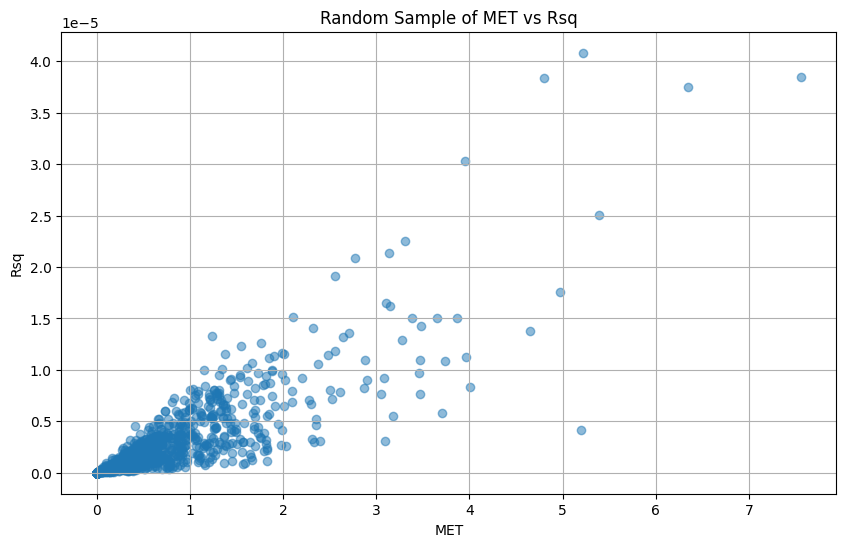

In [26]:
sampled_df = dataset.sample(n=10000, random_state=1)

plt.figure(figsize=(10, 6))
plt.scatter(sampled_df['MET'], sampled_df['Rsq'], alpha=0.5)
plt.title('Random Sample of MET vs Rsq')
plt.xlabel('MET')
plt.ylabel('Rsq')
plt.grid(True)
plt.savefig('MET_vs_Rsq_sample.eps', format='eps', dpi=1000)
plt.show()

In [27]:
sampled_df = dataset.sample(n=10, random_state=1)

for index, row in sampled_df.iterrows():
    print(f"Row {index}: ", end="")
    print(", ".join([f"{col}: {row[col]}" for col in sampled_df.columns]))


Row 352806: Event Number: 352806, HT: 94.77461783614284, MET: 0.0, MR: 13999.999999935762, Rsq: 0.0, Dark Photon Produced: False
Row 417824: Event Number: 417824, HT: 48.96398228638034, MET: 0.0, MR: 14000.000000002048, Rsq: 0.0, Dark Photon Produced: False
Row 469847: Event Number: 469847, HT: 196.72133344854845, MET: 0.0, MR: 14000.000000802484, Rsq: 0.0, Dark Photon Produced: False
Row 407746: Event Number: 407746, HT: 118.22654088984034, MET: 1.068940449058131, MR: 13983.156707040764, Rsq: 2.5853422057025276e-06, Dark Photon Produced: False
Row 469848: Event Number: 469848, HT: 105.60457759122453, MET: 0.0, MR: 13999.99999998099, Rsq: 0.0, Dark Photon Produced: False
Row 494526: Event Number: 494526, HT: 31.646425933861455, MET: 0.0, MR: 13999.99999999672, Rsq: 0.0, Dark Photon Produced: False
Row 413659: Event Number: 413659, HT: 156.16166181592942, MET: 0.0, MR: 14000.000000068492, Rsq: 0.0, Dark Photon Produced: False
Row 243752: Event Number: 243752, HT: 25.75183153811676, MET: